# [1]. Read Dataset from Kaggle

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d snap/amazon-fine-food-reviews -f Reviews.csv

 90% 103M/115M [00:00<00:00, 119MB/s] 
100% 115M/115M [00:00<00:00, 147MB/s]


In [6]:
!unzip Reviews.csv

Archive:  Reviews.csv.zip
  inflating: Reviews.csv             


# [2]. Reading Dataset

In [7]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
dataset = pd.read_csv('Reviews.csv')

In [9]:
dataset.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [10]:
len(dataset)

568454

In [11]:
dataset.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [12]:
dataset.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [13]:
filtered_data = dataset[dataset["Score"] != 3]

In [14]:
len(filtered_data)

525814

In [15]:
filtered_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [16]:
def partition(x):
  if x<3:
    return 0
  return 1

In [17]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Filtered data shape: ", filtered_data.shape)
filtered_data.head(2)

Filtered data shape:  (525814, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# [3]. Exploratory Data Analysis

In [18]:
display = filtered_data.groupby('UserId').filter(lambda x: len(x)>1)

In [19]:
display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [20]:
display['Count'] = display.groupby('UserId')['UserId'].transform('count')

In [21]:
display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Count
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,3
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,3


In [22]:
display.drop_duplicates('UserId', keep='first', inplace=True)

In [23]:
display.shape

(75346, 11)

In [24]:
display['Count'].sum()

357746

In [25]:
display[display['UserId']=='AZY10LLTJ71NX']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Count
35173,35174,B001ATMQK2,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,1,1296691200,Have you seen how much Ranch 99 is trying to c...,I bought this 6 pack because for the price tha...,5


### Anomaly 1:

Same user has multiple reviews for a same product with the same values if helpfulness numerator, helpfulness denominator, score, time, summary and text

In [26]:
display = dataset[(dataset['UserId']=='AR5J8UI46CURR') & (dataset['Score']!=3)]

In [27]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [28]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [29]:
sorted_data.shape

(525814, 10)

In [30]:
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [31]:
(final['Id'].size*1.0) / (filtered_data['Id'].size*1.0)*100

69.25890143662969

### Anomaly 2:

value of helpfulness numerator is greater than helpfulness denominator which is practically impossible.

In [32]:
display = dataset[(dataset['Score']!=3) & ((dataset['Id'] == 44737) | (dataset['Id']==64422))]

In [33]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [34]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [35]:
final.shape

(364171, 10)

# [4]. Text Preprocessing

Preprocessing steps:
* Remove HTML tags
* Remove punctuations and special characters
* Remove alpha numberic words
* Check the length of the word is greater than 2
* Convert the word to lowercase
* Remove Stopwords
* Snowball Stemming

In [36]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [37]:
import re

Removal of URLS

In [38]:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_1500 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

Removal of HTML Elements and tags

In [39]:
from bs4 import BeautifulSoup

In [40]:
soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Expanding English language contractions

In [41]:
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [42]:
sent_4900 = decontracted(sent_4900)
print(sent_4900)

Ca not do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


Removal of words with numbers

In [43]:
sent_0 = re.sub(r"\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Removal of special characters

In [44]:
sent_1500 = re.sub('[^A-Za-z0-9]+', "", sent_1500)
print(sent_1500)

Greatingredientsalthoughchickenshouldhavebeen1stratherthanchickenbroththeonlythingIdonotthinkbelongsinitisCanolaoilCanolaorrapeseedisnotsometingadogwouldeverfindinnatureandifitdidfindrapeseedinnatureandeatititwouldpoisonthemTodaysFoodindustrieshaveconvincedthemassesthatCanolaoilisasafeandevenbetteroilthanoliveorvirgincoconutfactsthoughsayotherwiseUntilthelate70sitwaspoisonousuntiltheyfiguredoutawaytofixthatIstilllikeitbutitcouldbebetter


Removal of Stopwords

In [45]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [46]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [02:22<00:00, 2562.16it/s]


In [47]:
len(preprocessed_reviews)

364171

In [48]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [49]:
final.shape

(364171, 10)

In [50]:
count = 0
ind = 0
index_lst = []
for x in preprocessed_reviews:
  if pd.isna(x) == True:
    count+=1
    index_lst.append(ind)
  ind+=1
print(count)
print(index_lst)

0
[]


In [51]:
final['preprocessed_reviews'] = preprocessed_reviews

In [52]:
final.shape

(364171, 11)

In [78]:
final.to_csv('/content/drive/MyDrive/Colab Notebooks/Amazon_fine_food_reviews/preprocessed_review_file.csv')

In [88]:
final.loc[276]

Id                                                                      277
ProductId                                                        B000LKZK7C
UserId                                                       A1YZV2UY0QDZTX
ProfileName                                           Loves to Cook "Loves"
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    2
Score                                                                     1
Time                                                             1253750400
Summary                                                          Excellent!
Text                      Great service! Items arrived faster than expec...
preprocessed_reviews      great service items arrived faster expected ef...
Name: 276, dtype: object

In [79]:
# final1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Amazon_fine_food_reviews/preprocessed_review_file.csv')

In [81]:
# preprocessed_reviews = final1['preprocessed_reviews']

In [82]:
# len(preprocessed_reviews)

364171

In [53]:
preprocessed_reviews1 = preprocessed_reviews[:10000]

In [54]:
score = final['Score'].values
print(len(score))
y = score[:10000]

364171


In [55]:
len(preprocessed_reviews1)

10000

In [56]:
count = 0
ind = 0
index_lst = []
for x in preprocessed_reviews1:
  if pd.isna(x) == True:
    count+=1
    index_lst.append(ind)
  ind+=1
print(count)
print(index_lst)

0
[]


In [25]:
print(preprocessed_reviews[276])

nan


# [5]. Featurization

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

### [5.1]. Bag of Words

In [58]:
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews1)
print("some feature names :", count_vect.get_feature_names()[:10])
print("="*50)

final_counts = count_vect.transform(preprocessed_reviews1)
print(type(final_counts))
print(final_counts.get_shape())
print(final_counts.get_shape()[1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


some feature names : ['aa', 'aaaaa', 'aaaaaahhhhhyaaaaaa', 'aaaallll', 'aaah', 'aaahhhhhh', 'aafco', 'aahing', 'ab', 'abandon']
<class 'scipy.sparse.csr.csr_matrix'>
(10000, 22363)
22363


### [5.2]. Bi-Grams and n-grams

In [59]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigrams_counts = count_vect.fit_transform(preprocessed_reviews1)

print(type(final_bigrams_counts))
print(final_bigrams_counts.get_shape())
print(final_bigrams_counts.get_shape()[1])

<class 'scipy.sparse.csr.csr_matrix'>
(10000, 6457)
6457


### [5.3]. TF-IDF

In [60]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews1)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews1)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'able use', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 6457)
the number of unique words including both unigrams and bigrams  6457


### [5.4]. Word2Vec

In [61]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in preprocessed_reviews1:
    list_of_sentence.append(sentence.split())

In [62]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9309220314025879), ('good', 0.8929112553596497), ('wonderful', 0.8699600696563721), ('works', 0.8517550230026245), ('uniqueness', 0.804754912853241), ('excelent', 0.8038772940635681), ('healthy', 0.7926725745201111), ('value', 0.7923759818077087), ('reccommend', 0.7841523885726929), ('nice', 0.7797530293464661)]
[('eaten', 0.994083821773529), ('loving', 0.9925194382667542), ('finest', 0.9918389320373535), ('miss', 0.9897218346595764), ('agree', 0.9894616603851318), ('hated', 0.9894323945045471), ('horrible', 0.9883766174316406), ('class', 0.9881769418716431), ('movies', 0.987859845161438), ('coffees', 0.987819254398346)]


In [63]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6818
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grew', 'reading', 'sendak', 'books', 'watching', 'really', 'movie', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes', 'two', 'hands', 'keep', 'pages', 'open', 'fun', 'way', 'children', 'learn']


### [5.5]. Converting text into vectors using wAvg W2V

In [64]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 10000/10000 [00:22<00:00, 449.30it/s]

10000
50


In [73]:
len(sent_vectors)

10000

### [5.5]. Convert text into vectors using TFIDF-W2V

In [65]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 10000/10000 [02:39<00:00, 62.56it/s]


# [6]. Applying TSNE

In [67]:
from sklearn.manifold import TSNE
from sklearn import datasets

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


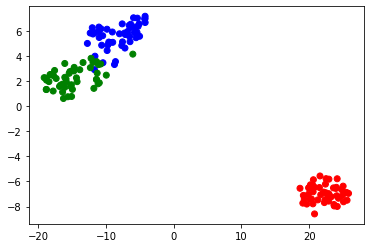

In [108]:
iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=150, random_state=1)

X_embedding = tsne.fit_transform(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'Score'])
colors = {0:"red", 1:"blue", 2:"green"}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

In [109]:
X_embedding.shape

(150, 2)

### [6.1]. Applying TSNE on Text BOW vectors

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


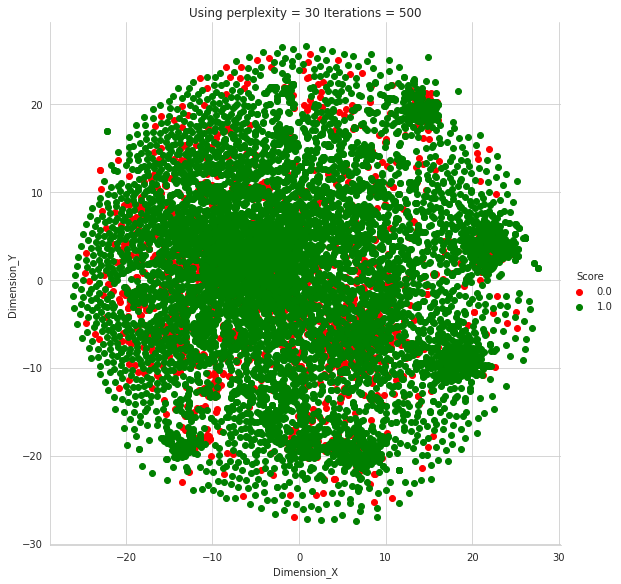

In [72]:
perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]

perplexity = 30 
iteration = 500
# converting the count vectors to sparse matrix form
x = final_counts.A

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,n_iter=iteration, n_jobs=-1).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
    .map(plt.scatter, "Dimension_X", "Dimension_Y") \
    .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

### [6.2]. Applying TSNE on Text TFIDF vectors

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


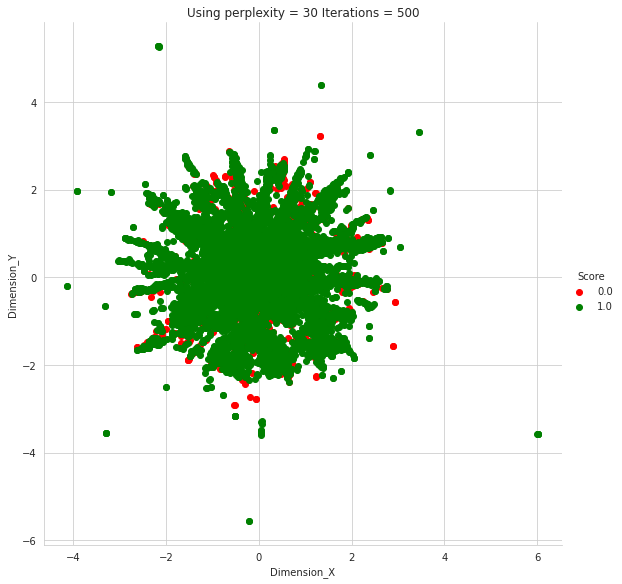

In [74]:
perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]

perplexity = 30 
iteration = 500
# converting the count vectors to sparse matrix form
x = final_tf_idf.A

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,n_iter=iteration, n_jobs=-1).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
    .map(plt.scatter, "Dimension_X", "Dimension_Y") \
    .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

### [6.3]. Applying TSNE on Text Avg W2V vectors

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


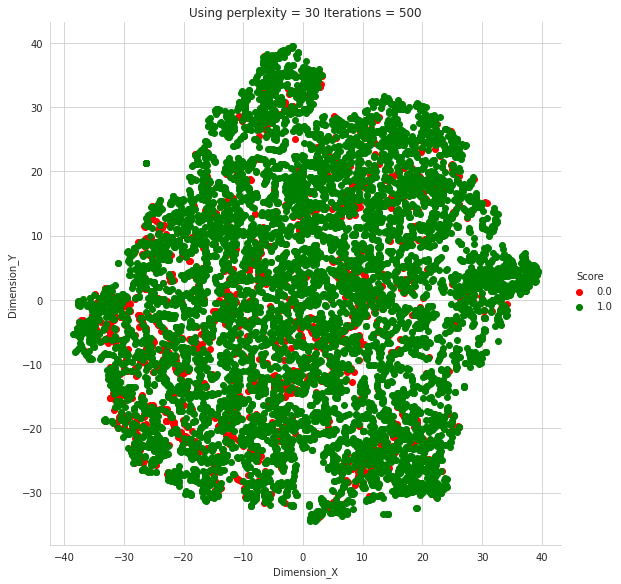

In [75]:
perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]

perplexity = 30 
iteration = 500
# converting the count vectors to sparse matrix form
x = sent_vectors

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,n_iter=iteration, n_jobs=-1).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
    .map(plt.scatter, "Dimension_X", "Dimension_Y") \
    .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

### [6.4]. Applying TSNE on Text TFIDF weighted W2V vectors

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


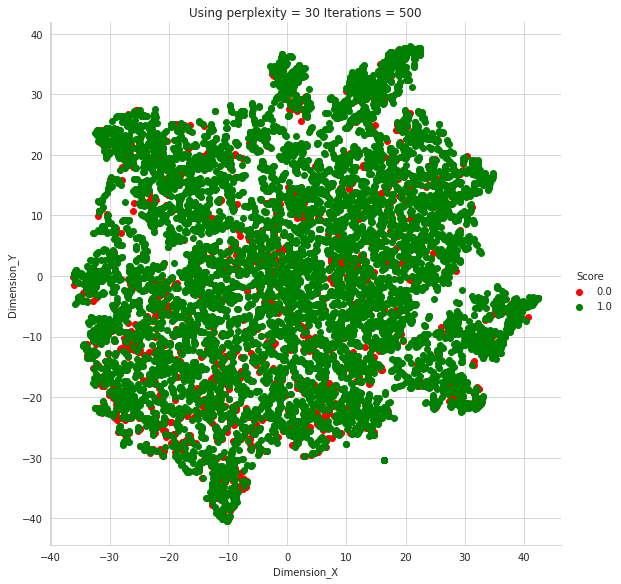

In [76]:
perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]

perplexity = 30 
iteration = 500
# converting the count vectors to sparse matrix form
x = tfidf_sent_vectors

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,n_iter=iteration, n_jobs=-1).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
    .map(plt.scatter, "Dimension_X", "Dimension_Y") \
    .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

# [7]. Conclusions

* For the BOW vectorization we do not get a good representation of data as it is a simple count based technique. Although we see some grouping shows up in this but that is only for small value of perplexity (neighbourhood). There is no consideration of meanings or symantic similarity in BOW

* The Tf-IDF representation proves to be much better as compared to the BOW representation as it tries to focus on the unique words from the corpus rather than simple count based scoring. On smaller values of perlexity it is successfully able to single out the negative reviews

* As for the average word2Vec representation, theoretically it should beat the above two representations with ease but in almost all the observations we see the positive reviews scattered uniformly with the negative reviews dotting the plot in random positions. Although for large values of perplexity and iterations we see a shift in the position of negative reviews to upper region of the plot.

* As for the Tf-IDF weighted word2Vec representation we do not see any significant improvement from the average word2Vec.

**We know the word2Vec to be one of the best representations, but we do not see it helping to demarcate the positive and negative reviews very prominently, in this experiment. One reason we can point out for this is that possibly 50 dims is far too less to catch the entire information, and applying TSNE after that further cause info loss. We are unable to increase dimensions due to hardware constraints.**